In [2]:
from sys import argv
from math import log, exp
from random import randrange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn import metrics
from sklearn.preprocessing import MaxAbsScaler
from sklearn.utils import shuffle
from sklearn import preprocessing

#--[Basic Function]---------------------------------------------------------------------
#input decision_values, real_labels{1,-1}, #positive_instances, #negative_instances
#output [A,B] that minimize sigmoid likilihood
#refer to Platt's Probablistic Output for Support Vector Machines
def SigmoidTrain(deci, label, A = None, B = None, prior0=None,prior1=None):
    #Count prior0 and prior1 if needed
    if prior1==None or prior0==None:
        prior1, prior0 = 0, 0
        for i in range(len(label)):
            if label[i] > 0:
                prior1+=1
            else:
                prior0+=1

    #Parameter Setting
    maxiter=1000	#Maximum number of iterations
    minstep=1e-10	#Minimum step taken in line search
    sigma=1e-12	#For numerically strict PD of Hessian
    eps=1e-5
    length = len(deci)
    
    #Construct Target Support
    hiTarget=(prior1+1.0)/(prior1+2.0)
    #print(hiTarget)
    loTarget=1/(prior0+2.0)
    length=prior1+prior0
    t=[]

    for i in range(length):
        if label[i] > 0:
            t.append(hiTarget)
        else:
            t.append(loTarget)
    #print(np.mean(t))
    #Initial Point and Initial Fun Value
    A,B=0.0, log((prior0+1.0)/(prior1+1.0))
    #print("A,B",A,B)
    fval = 0.0

    for i in range(length):
        fApB = deci[i]*A+B
        
        if fApB >= 0: # Positive class hence label will be +1 
            fval += t[i]*fApB + log(1+exp(-fApB))
        else: # Negative class label will be -1
            fval += (t[i] - 1)*fApB +log(1+exp(fApB))

    for it in range(maxiter):
        #Update Gradient and Hessian (use H' = H + sigma I)
        h11=h22=sigma #Numerically ensures strict PD
        h21=g1=g2=0.0
        for i in range(length):
            fApB = deci[i]*A+B
            if (fApB >= 0):
                p=exp(-fApB)/(1.0+exp(-fApB))
                q=1.0/(1.0+exp(-fApB))
            else:
                p=1.0/(1.0+exp(fApB))
                q=exp(fApB)/(1.0+exp(fApB))
            d2=p*q
            h11+=deci[i]*deci[i]*d2
            h22+=d2
            h21+=deci[i]*d2
            d1=t[i]-p
            g1+=deci[i]*d1
            g2+=d1

        #Stopping Criteria
        if abs(g1)<eps and abs(g2)<eps:
            break

        #Finding Newton direction: -inv(H') * g
        det=h11*h22-h21*h21
        dA=-(h22*g1 - h21 * g2) / det
        dB=-(-h21*g1+ h11 * g2) / det
        gd=g1*dA+g2*dB

        #Line Search
        stepsize = 1
        while stepsize >= minstep:
            newA = A + stepsize * dA
            newB = B + stepsize * dB

            #New function value
            newf = 0.0
            for i in range(length):
                fApB = deci[i]*newA+newB
                if fApB >= 0:
                    newf += t[i]*fApB + log(1+exp(-fApB))
                else:
                    newf += (t[i] - 1)*fApB +log(1+exp(fApB))

            #Check sufficient decrease
            if newf < fval + 0.0001 * stepsize * gd:
                A, B, fval = newA, newB, newf
                break
            else:
                stepsize = stepsize / 2.0

        if stepsize < minstep:
            print("line search fails",A,B,g1,g2,dA,dB,gd)
            
            return [A,B]

    if it>=maxiter-1:
        print("reaching maximal iterations",g1,g2)
    return (A,B,fval)

#reads decision_value and Platt parameter [A,B]
#outputs predicted probability

def SigmoidPredict(deci, AB):
    A, B = AB
    fApB = deci * A + B
    if (fApB >= 0):
        return exp(-fApB)/(1.0+exp(-fApB))
    else:
        return 1.0/(1+exp(fApB)) 
    return prob

def Expectation(score, A, B):
    t = []
    for i in range(len(score)):
        if A*score[i] + B >= 0:
            t.append(1)
        else:
            t.append(0)
    p = np.mean(t)
    t[t == 0] = -1
    #print(t)
    return t


def EM(score, A_init, B_init, prior0, prior1, maxit=1000, tol=1e-8):
  # Estimation of parameter(Initial)
    flag = 0
    A_cur = A_init 
    B_cur = B_init
    A_new = 0.0
    B_new = 0.0
  
  # Iterate between expectation and maximization parts
  
    for i in range(maxit):
        #print(i)
        if(i != 0):
            (A_new, B_new) = SigmoidTrain(score,Expectation(score, A_cur, B_cur), A_cur, B_cur)
            #print(A_new, B_new)
        else:
            t = []
            for i in range(len(score)):
                if A_cur*score[i] + B_cur >= 0:
                    t.append(1)
                else:
                    t.append(0)
            t[t == 0] = -1
            (A_new, B_new) = SigmoidTrain(score,t, A_cur, B_cur, prior0, prior1)
            #print(A_new, B_new)    
        
        # Stop iteration if the difference between the current and new estimates is less than a tolerance level
        if(A_cur - A_new < tol and B_cur - B_new < tol):
            flag = 1
            #break    
        # Otherwise continue iteration
        A_cur = A_new 
        B_cur = B_new
    if(not flag):
        print("Didn't converge\n")
  
    return (A_cur, B_cur)

def SigmoidFitting(score, proportion):
    fval = []
    A = []
    B = []
    sorted_score = list(sorted(set(np.round(score, decimals = 2))))
    for i in range(int(proportion*len(sorted_score))):            
        threshold = sorted_score[i]
        print(threshold)
        t = [1 if j <= threshold else -1 for j in score]
        (a, b, f) = SigmoidTrain(score,t)
        A.append(a)
        B.append(b)
        fval.append(f)
    return(A,B,fval)

def SigmoidFittingGrid(score, proportion):
    ngrid = score.shape[1]
    fval = []
    A = []
    B = []
    threshold = []
    for param in range(ngrid):
        a,b,f = SigmoidFitting(score[:,param], proportion)
        fval.append(min(f))
        A.append(a[np.argmin(f)])
        B.append(b[np.argmin(f)])
        threshold.append(score[np.argmin(f),param])
    return A,B,fval,threshold
        

def ContextualForest(contexts, features, features_cat, features_num, gamma_range, ncontexts = None):
    #contexts = shuffle(contexts)
    if(not ncontexts):
        ncontexts = contexts.shape[0]
    context_scores = np.zeros((ncontexts,features.shape[0],len(gamma_range)))
    for i in range(ncontexts):
        context = list(contexts.iloc[i,])
        print(context)
        feature_names = list(features)
        context_features = list()
        behavioral_features = list()
        
        for feat in feature_names:
                c = feat.split("_")
                if len(set(c).intersection(set(context))) > 0 or feat in context:
                    context_features.append(feat)
                else:
                    behavioral_features.append(feat)
        context_f = features[context_features]
        behav_f = features[behavioral_features]
        
        # Finding the categorical and numerical features in context features.
        if(features_cat != None):
            cat_names = list(features_cat)
            cat_context = list(set(context_f).intersection(set(cat_names)))
            context_f_cat = context_f[cat_context]
            num_names = list(features_num)
            num_context = list(set(context_f).intersection(set(num_names)))
            context_f_num = context_f[num_context]
            # Finding the distances of the context space

            cat_context_distance = metrics.pairwise.cosine_similarity(np.array(context_f_cat))
            # Scaling the numerical data using MaxAbsScaler
            context_f_num_scaled = MaxAbsScaler().fit_transform(np.array(context_f_num))
            # Zero mean and unit variance scaling
            #context_f_num_scaled = preprocessing.scale(context_f_num)
            #num_context_distance = metrics.pairwise.euclidean_distances(context_f_num_scaled)

            #print("Cat distance",cat_context_distance)
            for gamma in range(len(gamma_range)): 
                print(gamma_range[gamma])
                num_context_distance = metrics.pairwise.rbf_kernel(context_f_num_scaled, gamma= gamma_range[gamma])
                #print("Num distance",num_context_distance)
                context_distance = np.minimum(cat_context_distance,num_context_distance)
                #context_distance = num_context_distance
                rng = np.random.RandomState(42)
                clf = IsolationForest(max_samples=256, random_state=rng, smoothing = True)
                clf.fit(behav_f, context_distance)
                context_scores[i,:,gamma] = clf.decision_function(behav_f,distance=context_distance)
        else:
            num_names = list(features_num)
            num_context = list(set(context_f).intersection(set(num_names)))
            context_f_num = context_f[num_context]
            # Finding the distances of the context space

            # Scaling the numerical data using MaxAbsScaler
            context_f_num_scaled = MaxAbsScaler().fit_transform(np.array(context_f_num))
            # Zero mean and unit variance scaling
            #context_f_num_scaled = preprocessing.scale(context_f_num)
            #num_context_distance = metrics.pairwise.euclidean_distances(context_f_num_scaled)

            #print("Cat distance",cat_context_distance)
            for gamma in range(len(gamma_range)): 
                print(gamma_range[gamma])
                num_context_distance = metrics.pairwise.rbf_kernel(context_f_num_scaled, gamma= gamma_range[gamma], )
                #print("Num distance",num_context_distance)
                #context_distance = np.minimum(cat_context_distance,num_context_distance)
                context_distance = num_context_distance
                rng = np.random.RandomState(42)
                clf = IsolationForest(max_samples=256, random_state=rng, smoothing = True)
                clf.fit(behav_f, context_distance)
                context_scores[i,:,gamma] = clf.decision_function(behav_f,distance=context_distance)           
        
    return context_scores

In [ ]:
# Play Arena Test times of the implementation.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn import metrics

rng = np.random.RandomState(42)

# Generate train data
X = 0.3 * rng.randn(5000, 2)
X_train = np.r_[X + 2, X - 2]

# fit the iForest model
# distance = np.ones((X_train.shape[0], X_train.shape[0]))
# clf = IsolationForest(random_state=rng, smoothing = False)
# import timeit
# start_time = timeit.default_timer()
# clf.fit(X_train, distance)
# y_pred_train = clf.decision_function(X_train, distance)
# print("iForest:",timeit.default_timer() - start_time)
# # fit the cForest model

distance = metrics.pairwise.rbf_kernel(X_train, gamma= 10000)

clf = IsolationForest(random_state=rng, smoothing = True)
import timeit
start_time = timeit.default_timer()
clf.fit(X_train, distance)
y_pred_train = clf.decision_function(X_train, distance)
print("cForest:",timeit.default_timer() - start_time)


In [4]:
# Loading the feature matrix and the context from the UnifiedMeasure.
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import pandas as pd
import numpy as np
pandas2ri.activate()

# Feat matrix 2 will need to be saved as data frame in the R script.
readRDS = robjects.r['readRDS']
df_feat = readRDS('features_pen.RDS')
df_feat = pandas2ri.ri2py_dataframe(df_feat)
#df_feat = pd.DataFrame(np.transpose(df_feat))

# Contexts are being stored as data frames in R.
df_contexts = readRDS('contextpens.RDS')
df_contexts = pandas2ri.ri2py_dataframe(df_contexts) 
#df_contexts = pd.DataFrame(df_contexts)

# Loading typevar 
df_typevar = readRDS('typevar_pen.RDS')
df_typevar = pandas2ri.ri2py_dataframe(df_typevar) 

# Loading ground truth 
labels = readRDS('labels_pen.RDS')
labels = pandas2ri.ri2py(labels)
len(labels)

6870

In [5]:
# Getting dummies for isolation forest input
#test = pd.get_dummies(df_feat)
df_typevar.head(10)
categorical = df_typevar[df_typevar['typevar'] == "categorical"].index.tolist()
other = df_typevar[df_typevar['typevar'] != "categorical"].index.tolist()
# adjusting for indices in py
categorical = [i-1 for i in categorical]
other = [i-1 for i in other]

In [6]:
# Handling for no categorical features. 
if(len(categorical)):
    df_feat_cat = df_feat.iloc[:,categorical]
    df_feat_other = df_feat.iloc[:,other]
    df_feat_cat = pd.get_dummies(df_feat_cat)
    df_feat_all = pd.concat([df_feat_other, df_feat_all], axis=1)
else:
    df_feat_other = df_feat.iloc[:,other]
    df_feat_all = df_feat_other
    df_feat_cat = None
# The full feature list in built and ready to be passed to iForest.

In [7]:
gamma_range = [0.0001,0.001,0.01,0.1,1,10,100,1000]

In [ ]:
import timeit
start_time = timeit.default_timer()
scores = ContextualForest(df_contexts, df_feat_all, df_feat_cat, df_feat_other,
                          gamma_range = gamma_range)
print(timeit.default_timer() - start_time)

In [ ]:
#np.savez("scores_r5.npz",scores)
np.savez("scores_all_pens.npz",scores)
#scores = np.load("scores_all_pens.npz")["arr_0"]
#fscores = np.median(scores, axis = 0)
scores #Each row corresponds to a context with varying gammas

In [ ]:
# Aggregating the scores
fscores = (scores - np.amin(scores, axis = 1, keepdims= True))/(np.amax(scores,axis =1, keepdims=True) - np.amin(scores,axis = 1,
                                                                                                                keepdims=True))
fscores = np.min(fscores, axis = 0)
fscores = np.array(fscores)
fscores

In [ ]:
ABft = SigmoidFittingGrid(fscores, proportion = 0.1)
print(ABft)

In [ ]:
A,B,f,t = ABft
A,B,fmin = A[np.argmin(f)],B[np.argmin(f)],min(f)
print("A:",A,"B:",B,"f:",f)
print("Threshold:",t[np.argmin(f)])
print("Gamma Chosen:",gamma_range[np.argmin(f)])
fgscores = fscores[:,np.argmin(f)]

In [ ]:
ABf = SigmoidFitting(fscores, proportion = 0.2)
print(ABf)

In [ ]:
A,B,f = ABf
A,B,f = A[np.argmin(f)],B[np.argmin(f)],min(f)
print("A:",A,"B:",B,"f:",f)
print("Threshold:",fscores[np.argmin(f)])

In [ ]:
import random
import numpy
from matplotlib import pyplot

inliers = fgscores[np.where(labels == 0)]
outliers = fgscores[np.where(labels == 1)]

pyplot.hist(inliers,  alpha=0.5, label='inliers')
pyplot.legend(loc='upper right')
pyplot.show()

pyplot.hist(outliers,  alpha=0.5, label='outliers')
pyplot.legend(loc='upper right')
pyplot.show()

import seaborn as sns
fig, ax = plt.subplots()
sns.distplot(outliers, hist=False, label = "outliers")
sns.distplot(inliers, hist=False, label = "inliers")

In [ ]:
fgscores[np.where(labels == 0)]

In [43]:
prob = []
for i in range(len(fscores)):
    prob.append(SigmoidPredict(fgscores[i],(A,B)))
np.mean(prob)
#prob = (prob - np.min(prob))/(np.max(prob) - np.min(prob))

0.0002425583451571049

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Fixing random state for reproducibility
np.random.seed(19680801)

# the histogram of the data
#n, bins, patches = plt.hist(prob, 50, normed=1, facecolor='g', alpha=0.75)
plt.scatter(fgscores, prob, c="g", alpha=0.5)
plt.xlim((0,1))
plt.ylim((0,1))
plt.ylabel('Probability Estimate')
plt.xlabel('Contextual iForest Score')
plt.title("Fraud Data")

In [22]:
# No Context iForest
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=512, random_state=rng, smoothing = False)
distance = np.ones((len(df_feat_all), len(df_feat_all)), order = "f")
clf.fit(df_feat_all, distance)
ifscores = clf.decision_function(df_feat_all,distance)


In [23]:
# LoF analysis
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=200)
y_pred = clf.fit_predict(df_feat_all)
lof_scores = clf.negative_outlier_factor_


In [ ]:
from sklearn.metrics import precision_recall_curve, auc
f, axes = plt.subplots(1, 1, figsize=(7, 5))
y_real = list(labels)
y_proba = []
fscores = (scores - np.amin(scores, axis = 1, keepdims= True))/(np.amax(scores,axis =1, keepdims=True) - np.amin(scores,axis = 1,
                                                                                                                keepdims=True))
fscores = np.min(fscores, axis = 0)
fscores = np.array(fscores)
for i in range(len(gamma_range)):
    precision, recall, _ = precision_recall_curve(labels, -1*fscores[:,i])
    lab = 'Gamma: %f AUC=%.4f' % (gamma_range[i], auc(recall, precision))
    axes.step(recall, precision, label=lab)
    y_real.append(labels)
    y_proba.append(-1*fscores[:,i])

precision, recall, _ = precision_recall_curve(labels, -1*ifscores)
y_real.append(labels)
y_proba.append(-1*ifscores)
lab = 'No Context iForest AUC=%.4f' % (auc(recall, precision))
axes.step(recall, precision, label=lab, lw=2, color='black')

precision, recall, _ = precision_recall_curve(labels, -1*lof_scores)
y_real.append(labels)
y_proba.append(-1*lof_scores)
lab = 'No Context LOF AUC=%.4f' % (auc(recall, precision))
axes.step(recall, precision, label=lab, lw=2)

axes.set_xlabel('Recall')
axes.set_ylabel('Precision')
axes.legend(loc='upper right', fontsize='small')

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
f, axes = plt.subplots(1, 1, figsize=(7, 5))
y_real = list(labels)
y_proba = []
# fscores = np.min(scores, axis = 0)
# fscores = (fscores - np.amin(fscores, axis = 0))/(np.amax(fscores,axis =0) - np.amin(fscores,axis = 0))
# fscores = np.array(fscores)

precision, recall, _ = precision_recall_curve(labels, -1*fgscores)
lab = 'ContextualForest: AUC=%.4f' % ( auc(recall, precision))
axes.step(recall, precision, label=lab)
y_real.append(labels)
y_proba.append(-1*fgscores)

precision, recall, _ = precision_recall_curve(labels, -1*ifscores)
y_real.append(labels)
y_proba.append(-1*ifscores)
lab = 'iForest: AUC=%.4f' % (auc(recall, precision))
axes.step(recall, precision, label=lab, lw=2, color='black')

precision, recall, _ = precision_recall_curve(labels, -1*lof_scores)
y_real.append(labels)
y_proba.append(-1*lof_scores)
lab = 'LOF: AUC=%.4f' % (auc(recall, precision))
axes.step(recall, precision, label=lab, lw=2, color='red')

axes.set_xlabel('Recall')
axes.set_ylabel('Precision')
axes.legend(loc='upper right', fontsize='small')

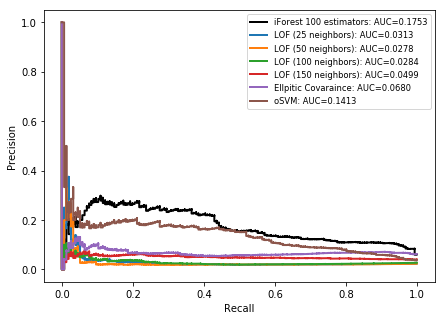

In [9]:
from sklearn.metrics import precision_recall_curve, auc
h, axes = plt.subplots(1, 1, figsize=(7, 5))
y_real = list(labels)
y_proba = []

# rng = np.random.RandomState(42)
# clf = IsolationForest(max_samples=256, random_state=rng, n_estimators=5400, smoothing = False)
# distance = np.ones((len(df_feat_all), len(df_feat_all)), order = "f")
# clf.fit(df_feat_all, distance)
# ifscores = clf.decision_function(df_feat_all,distance)

# precision, recall, _ = precision_recall_curve(labels, -1*ifscores)
# lab = 'iForest with 100*K estimators: AUC=%.4f' % ( auc(recall, precision))
# axes.step(recall, precision, label=lab,  lw = 2)
# y_real.append(labels)
# y_proba.append(-1*ifscores)

rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=256, random_state=rng, n_estimators=100, smoothing = False, max_features= 5)
distance = np.ones((len(df_feat_all), len(df_feat_all)), order = "f")
clf.fit(df_feat_all, distance)
ifscores = clf.decision_function(df_feat_all,distance)

precision, recall, _ = precision_recall_curve(labels, -1*ifscores)
y_real.append(labels)
y_proba.append(-1*ifscores)
lab = 'iForest 100 estimators: AUC=%.4f' % (auc(recall, precision))
axes.step(recall, precision, label=lab, lw=2, color='black')

# LoF analysis

from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=25)
y_pred = clf.fit_predict(df_feat_all)
lof_scores = clf.negative_outlier_factor_

precision, recall, _ = precision_recall_curve(labels, -1*lof_scores)
y_real.append(labels)
y_proba.append(-1*lof_scores)
lab = 'LOF (25 neighbors): AUC=%.4f' % (auc(recall, precision))
axes.step(recall, precision, label=lab, lw=2)

from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=50)
y_pred = clf.fit_predict(df_feat_all)
lof_scores = clf.negative_outlier_factor_

precision, recall, _ = precision_recall_curve(labels, -1*lof_scores)
y_real.append(labels)
y_proba.append(-1*lof_scores)
lab = 'LOF (50 neighbors): AUC=%.4f' % (auc(recall, precision))
axes.step(recall, precision, label=lab, lw=2)

# LoF analysis
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=100)
y_pred = clf.fit_predict(df_feat_all)
lof_scores = clf.negative_outlier_factor_

precision, recall, _ = precision_recall_curve(labels, -1*lof_scores)
y_real.append(labels)
y_proba.append(-1*lof_scores)
lab = 'LOF (100 neighbors): AUC=%.4f' % (auc(recall, precision))
axes.step(recall, precision, label=lab, lw=2)

# LoF analysis
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=150)
y_pred = clf.fit_predict(df_feat_all)
lof_scores = clf.negative_outlier_factor_

precision, recall, _ = precision_recall_curve(labels, -1*lof_scores)
y_real.append(labels)
y_proba.append(-1*lof_scores)
lab = 'LOF (150 neighbors): AUC=%.4f' % (auc(recall, precision))
axes.step(recall, precision, label=lab, lw=2)

# Elliptic Covariance
from sklearn.covariance import EllipticEnvelope
clf = EllipticEnvelope(contamination=0.1)
clf.fit(df_feat_all)
ell_scores = clf.decision_function(df_feat_all)

precision, recall, _ = precision_recall_curve(labels, -1*ell_scores)
y_real.append(labels)
y_proba.append(-1*ell_scores)
lab = 'Ellpitic Covaraince: AUC=%.4f' % (auc(recall, precision))
axes.step(recall, precision, label=lab, lw=2)


# One class SVM
from sklearn import svm
clf = svm.OneClassSVM(nu=0.95 * 0.1 + 0.05,
                                     kernel="rbf", gamma=0.1)
clf.fit(df_feat_all)
svm_scores = clf.decision_function(df_feat_all)
precision, recall, _ = precision_recall_curve(labels, -1*svm_scores)
y_real.append(labels)
y_proba.append(-1*svm_scores)
lab = 'oSVM: AUC=%.4f' % (auc(recall, precision))
axes.step(recall, precision, label=lab, lw=2)

axes.set_xlabel('Recall')
axes.set_ylabel('Precision')
axes.legend(loc='upper right', fontsize='small')